# Detecting patterns of speciation in the fossil records
<a href="https://courses.helsinki.fi/sites/default/files/course-material/4684892/fossil-analysis-assignment-2020.pdf" target="_blank">pdf instructions</a>

In [34]:
# Imports used in this project
from time import time # Checking time for optimiation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import statsmodels.api as sm
world = (geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')))


# Constants for the project.
# Mammal Neogene (MN) time units. Doesn't include MQ18/MQ19 from the table 1 of the pdf (like it shouldn't).
# Additional time units are pre-MN and post-MN
MN_UNITS = {'pre-MN': (1000000, 23), 'MN1': (23, 21.7), 'MN2': (21.7, 19.5), 'MN3': (19.5, 17.2), 'MN4': (17.2, 16.4), 'MN5': (16.4, 14.2),
               'MN6': (14.2, 12.85), 'MN7-8': (12.85, 11.2), 'MN9': (11.2, 9.9), 'MN10': (9.9, 8.9), 'MN11': (8.9, 7.6),
               'MN12': (7.6, 7.1), 'MN13': (7.1, 5.3), 'MN14': (5.3, 5), 'MN15': (5, 3.55), 'MN16': (3.55, 2.5),
               'MN17': (2.5, 1.9), 'post-MN': (1.9, 0)}

time_unit_order = MN_UNITS.keys() # Used to sort DataFrames for better readability

## Data preprocessing

1. First of all we need to get the data from the <a href="https://nowdatabase.org/" target="_blank">NOW database</a>. Include the species list with comma as a field separator, and save the given output as `.txt` file to our project folder.

2. Create a pandas `DataFrame` that contains all of the data and save it as a `.csv` file. How many rows does the `DataFrame` contain?

In [2]:
def txt_to_csv():
    df = pd.read_csv(r'fossil_data.txt')
    df.to_csv(r'fossil_data.csv', index=None)
    return df

if __name__ == '__main__':
    df = txt_to_csv()
    print(f'The DataFrame has: {len(df)} rows.')
    print(df.head(2)) # Testing the DataFrame

The DataFrame has: 67693 rows.
   LIDNUM       NAME      LATSTR      LONGSTR     LAT        LONG  MAX_AGE  \
0   21390      Aarau   47 23 0 N      8 3 0 E  47.383    8.050000  14.2000   
1   27232  Aba Zawei  33 15 00 N  102 25 00 E  33.250  102.416667   0.0295   

  BFA_MAX BFA_MAX_ABS FRAC_MAX  ...  MW_CS_ROUND MW_CS_BLUNT DIET_1  \
0     mn6          \N       \N  ...           \N          \N     \N   
1      \N         C14       \N  ...           \N          \N      p   

      DIET_2 DIET_3 LOCOMO1    LOCOMO2    LOCOMO3 SPCOMMENT SYNONYMS  
0         \N     \N      \N         \N         \N        \N       \N  
1  herbivore  graze      te  surficial  cursorial        \N       \N  

[2 rows x 87 columns]


### Answer
The `DataFrame` contains `67693` rows; excluding the column names.

### Cleaning the data
3. This exercise cleans the data and makes it usable.

In [3]:
def calculate_mn(mi, ma):
    avg = np.mean([mi, ma]) # Calculate the mean age with MIN_AGE (mi) and the MAX_AGE (ma)
    for key, (ma, mi) in MN_UNITS.items():
        if mi <= avg < ma:
            return key


def identify_species(genus, species, SIN_DICT):
    g_s = ' '.join((genus, species))
    UID = len(SIN_DICT)
    if g_s not in SIN_DICT:
        SIN_DICT[g_s] = UID
    return SIN_DICT[g_s]
    
    

def clean_df():
    df = pd.read_csv(r'fossil_data.csv')
    
    # Dropping rows based on instruction 3a
    df = df[(df.LAT != 0) & (df.LONG != 0)]
    df = df[(df.SPECIES != 'sp.') & (df.SPECIES != 'indet.')]
    
    # Adding MN column based on instruction 3b
    df['MN'] = [calculate_mn(mi, ma) for mi, ma in zip(df['MIN_AGE'], df['MAX_AGE'])]
    
    # Editing time units based on instruction 3c. Only 'Can Llobateres 1' needs to be modified
    df['MN'] = np.where(df['NAME'] == 'Can Llobateres 1', 'MN9', df['MN'])
    
    # Creating Species Identification Number (SIN) based on instruction 3d
    SIN_DICT = dict()
    df['SIN'] = [identify_species(genus, species, SIN_DICT) for genus, species in zip(df['GENUS'], df['SPECIES'])]
    
    # Dropping rows with the same species at the same locality based on instruction 3e
    df = df.drop_duplicates(subset=['NAME', 'SIN'])
    df.index = np.arange(0, len(df)) # Reset df index after removing rows
    
    return df


if __name__ == '__main__':
    df = clean_df()
    # Checking the amount of rows left, unique species and localities based on instruction 3f
    print(f'Rows left after step 3e: {len(df)}') # 49454 rows
    print(f'The amount of unique species: {max(df.SIN)+1}.') # 9849 uniques. Index starts at 0.
    print(f'The amount of unique localities: {len(set(df.NAME.values))}.') # 5500 localities

Rows left after step 3e: 49454
The amount of unique species: 9849.
The amount of unique localities: 5500.


### Answer
The `DataFrame` contains `49454` rows - excluding the column names -, `9849 unique species`, and `5500 unique localities`.

Notes: `List comprehension` is significantly faster than `pandas` own `apply()` method.

## Occurences
4. Creating a `DataFrame` that shows for each species how many occurrences it has in each time unit.

In [4]:
def build_MNs_for_species(idx, amt):
    # Initialize a dictionary with default value as 0
    columns = list(time_unit_order)
    columns.extend(['SIN'])
    occurence_dict = dict.fromkeys(columns, 0)
    sin, mn = idx
    occurence_dict['SIN'] = sin # Add Species ID
    occurence_dict[mn] = amt # Add amount of species found at certain time period
    return occurence_dict
    


def occurences_in_MN():
    main_df = clean_df()
    MN_unique = main_df.groupby('SIN').MN.value_counts().to_frame() # Count occurence of every MN for each species
    MN_occ = pd.DataFrame([build_MNs_for_species(idx, amt) for idx, amt in zip(MN_unique.index, MN_unique.MN)]) # Build DataFrame
    MN_occ = MN_occ.groupby('SIN', as_index=False).sum() # Merge the same species together
    return MN_occ

if __name__ == '__main__':
    df = occurences_in_MN()
    print(df.head(10)) # Testing DataFrame

   SIN  pre-MN  MN1  MN2  MN3  MN4  MN5  MN6  MN7-8  MN9  MN10  MN11  MN12  \
0    0       0    0    0    0    0    0    1      0    0     0     0     0   
1    1       0    0    0    0    0    0    0      0    0     0     0     0   
2    2       0    0    0    0    0    0    0      0    0     0     0     0   
3    3       0    0    0    0    0    0    0      0    0     0     0     0   
4    4       0    0    0    0    0    0    0      0    0     0     0     0   
5    5       0    0    0    0    0    0    0      0    0     0     0     0   
6    6       0    0    0    0    0    0    0      0    0     0     0     0   
7    7       0    0    0    0    0    0    0      0    0     0     0     0   
8    8       0    0    0    0    2    1   12     26   36    68    10    13   
9    9       0    0    0    0    1    1   14     35    3     0     0     0   

   MN13  MN14  MN15  MN16  MN17  post-MN  
0     0     0     0     0     0        0  
1     0     0     0     0     0       20  
2     0     

Creating a `DataFrame` that shows for each species the time unit when it is first observed

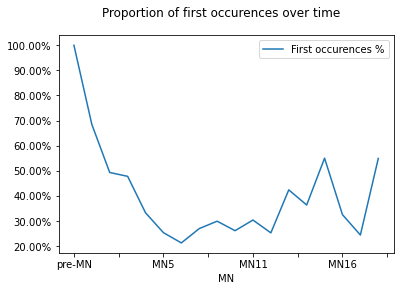

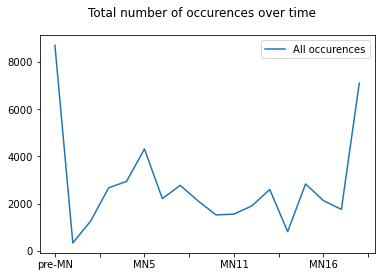

In [5]:
def species_first_occurences():
    all_occ = occurences_in_MN().set_index('SIN')
    first_occ = pd.DataFrame()
    first_occ['MN'] = all_occ.ne(0).idxmax(1) # Find the first observation for every species
    # Add count column for easier use for the next task
    first_occ['COUNT'] = all_occ.replace(0, np.nan).bfill(1).iloc[:, 0].astype(int)
    return first_occ

def proportion_of_first_occurences():
    main_df = clean_df()
    species = species_first_occurences()
    
    time_units_first_occ = species['MN'].value_counts()[time_unit_order] # First observation for every species
    time_units_all_occ = main_df.MN.value_counts()[time_unit_order] # All occurences in a dataframe
    all_species = species.groupby('MN').COUNT.sum()[time_unit_order] # All first observations of species
    
    proportion = pd.Series(all_species / time_units_all_occ)
    return proportion, time_units_all_occ # Return a tuple for easier plotting

if __name__ == '__main__':
    proportion, all_occurences = proportion_of_first_occurences()
    plot1 = plt.figure(1)
    ax1 = proportion.plot()
    to_percentage = ax1.get_yticks()
    ax1.set_yticklabels([f'{val:.2%}' for val in to_percentage]) # Format to percentage
    plt.suptitle('Proportion of first occurences over time')
    ax1.legend(['First occurences %'])
    
    plot1 = plt.figure(2)
    ax2 = all_occurences.plot()
    plt.suptitle('Total number of occurences over time')
    ax2.legend(['All occurences'])

### Answer
There's really nothing to add to the plots. I think the wording of the assignment was a bit ambiguous for some parts. 
It can be understood in few different ways. I'm optimistic that I got it right though.

Notes: `time_unit_order` is a constant that was initialize on the top of the notebook. It helps to debug the code with better readability.

5. Creating a new `DataFrame` that collects the following information for every locality: locality number (LIDNUM), longitude, latitude, time unit, number of first occurrences in the locality, number of all occurrences in the locality and proportion of first occurrences in the locality. We are then going to plot some of the gathered information.

In [6]:
def location_df():
    main_df = clean_df()[['LIDNUM', 'LONG', 'LAT', 'MN', 'SIN']] # Taking SIN for easier DF building
    species = species_first_occurences().to_dict() # Assign to dict for easier use
    
    # Temporary column which defines if a row is a first occurence or not
    main_df['TEMP'] = [1 if species['MN'][sin] == mn else 0 for sin, mn in zip(main_df['SIN'], main_df['MN'])]
    main_df['FIRST_OCC'] = main_df.groupby(['LIDNUM'])['TEMP'].transform('sum') # Amount of first occurences in the locality
    main_df['ALL_OCC'] = main_df.groupby(['LIDNUM'])['LIDNUM'].transform('count') # All occurences of the locality
    main_df['PROPORTION'] = round((main_df['FIRST_OCC'] / main_df['ALL_OCC']), 2)
    
    main_df.drop(columns=['TEMP', 'SIN'], inplace=True)
    main_df.drop_duplicates(subset=['LIDNUM'], inplace=True)
    return main_df

if __name__ == '__main__':
    df = location_df()
    print(df.head(20))

     LIDNUM        LONG        LAT       MN  FIRST_OCC  ALL_OCC  PROPORTION
0     21390    8.050000  47.383000      MN6          1        1        1.00
1     27232  102.416667  33.250000  post-MN          3        3        1.00
4     27955   -1.544182  39.209991     MN15          0        4        0.00
8     26550   46.533333  38.516667     MN12          0        1        0.00
9     28578    1.788000  41.532600    MN7-8          2        9        0.22
18    28579    1.788900  41.532600    MN7-8          1       10        0.10
28    28580    1.788900  41.532600    MN7-8          2        4        0.50
32    28581    1.788900  41.532600    MN7-8          3        8        0.38
40    28582    1.788900  41.532600    MN7-8          5       17        0.29
57    28583    1.788900  41.532600    MN7-8          6       16        0.38
73    28584    1.780000  41.530000    MN7-8          6       11        0.55
84    28585    1.788900  41.532600    MN7-8          3        6        0.50
90    28586 

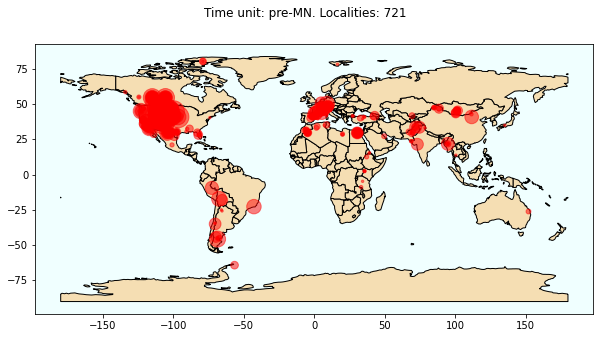

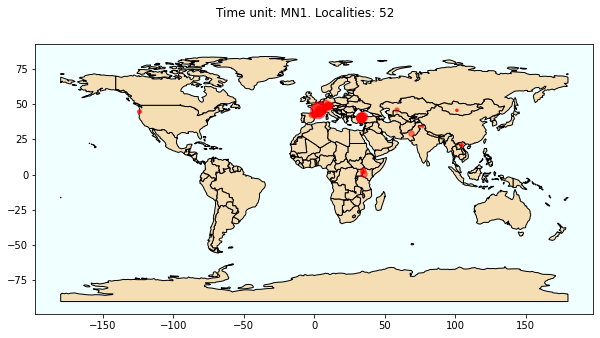

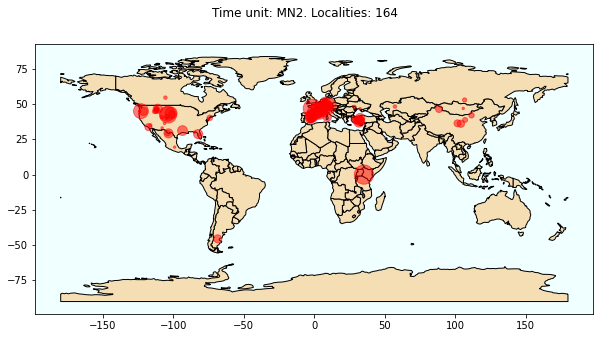

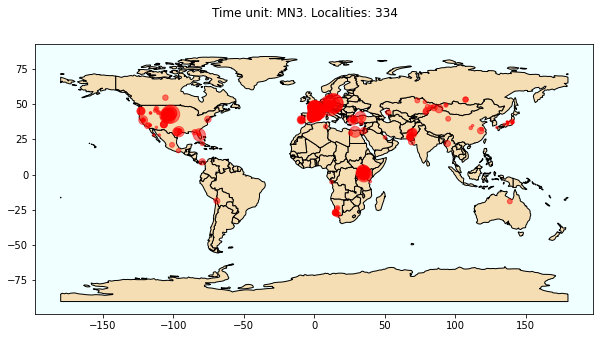

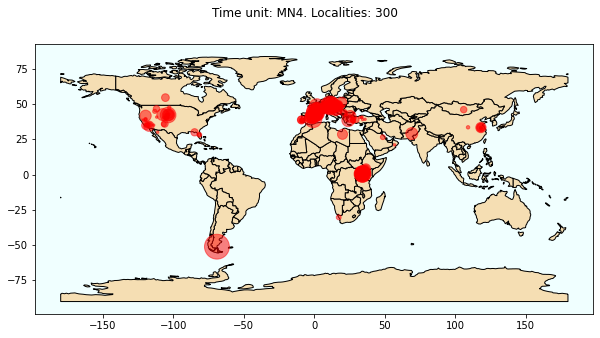

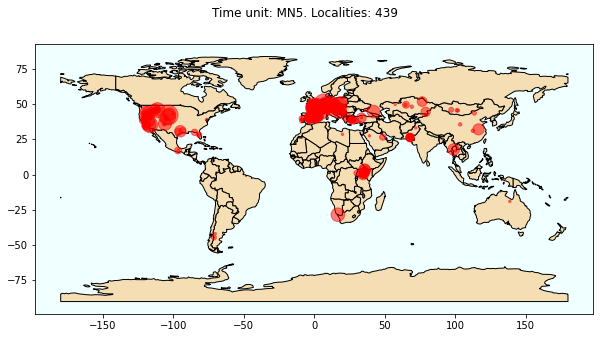

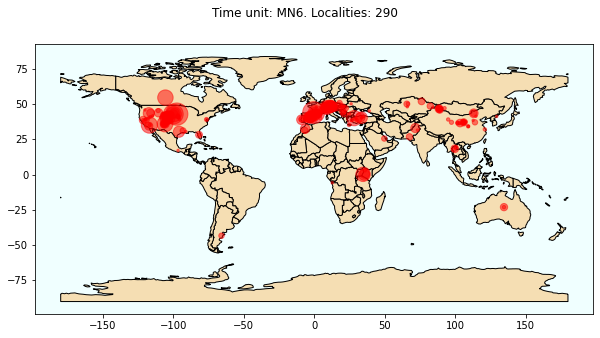

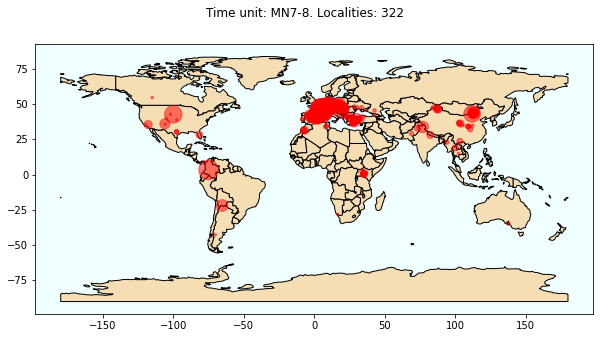

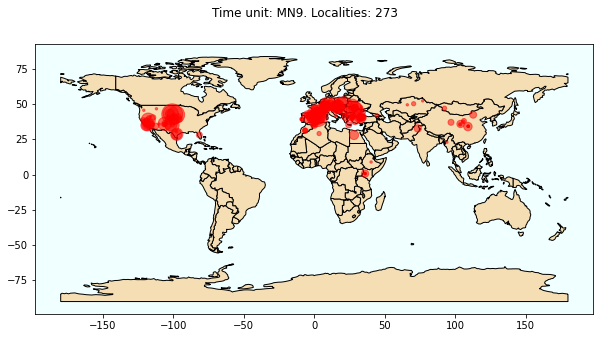

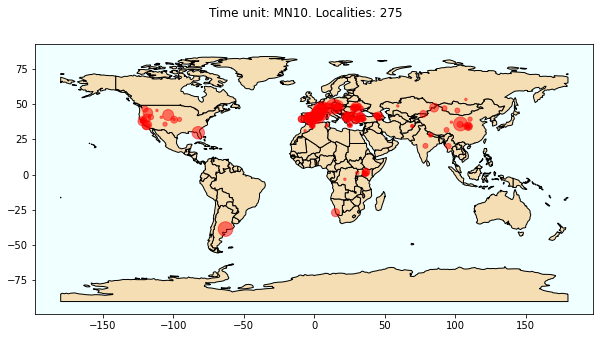

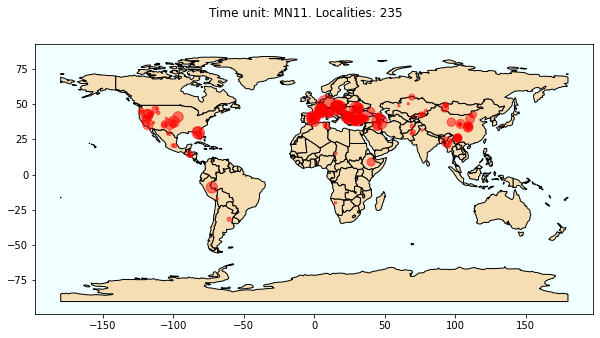

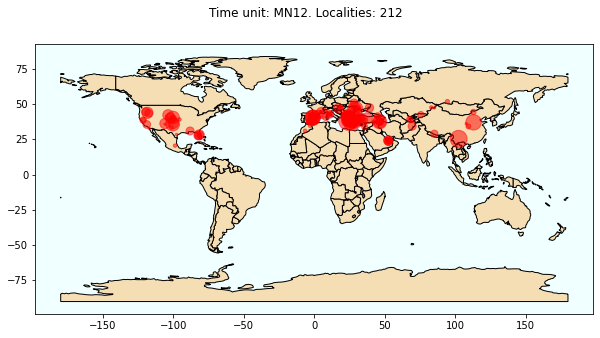

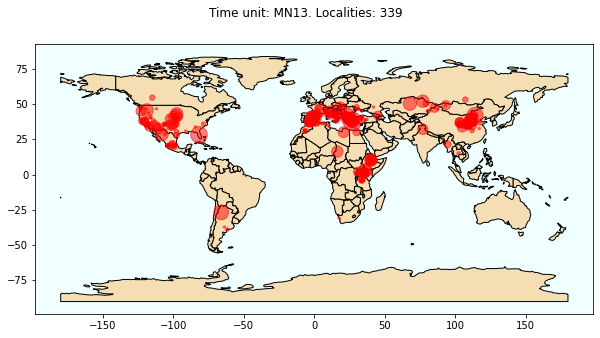

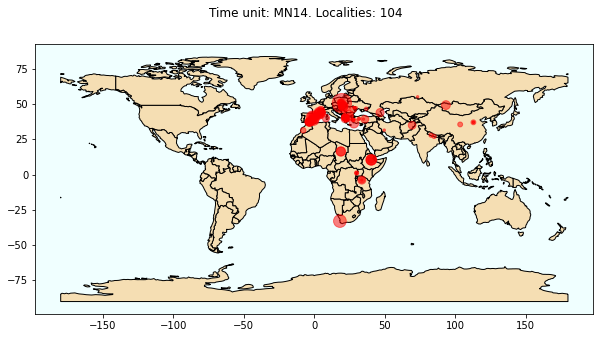

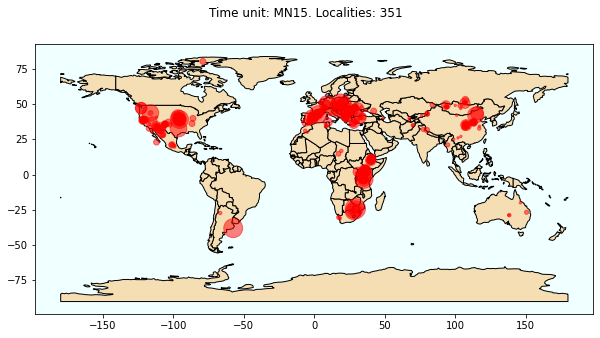

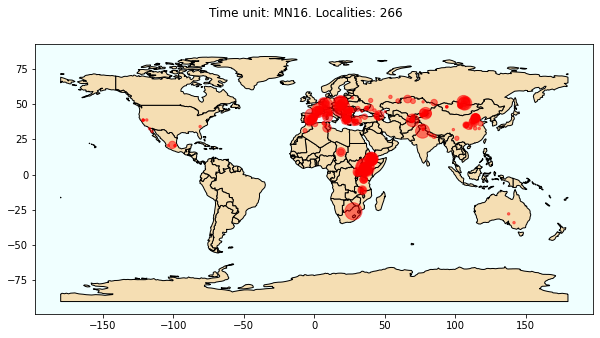

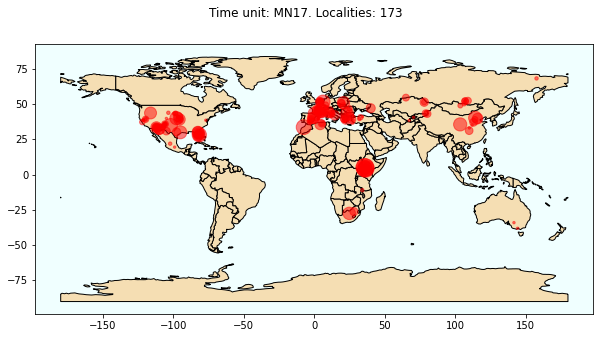

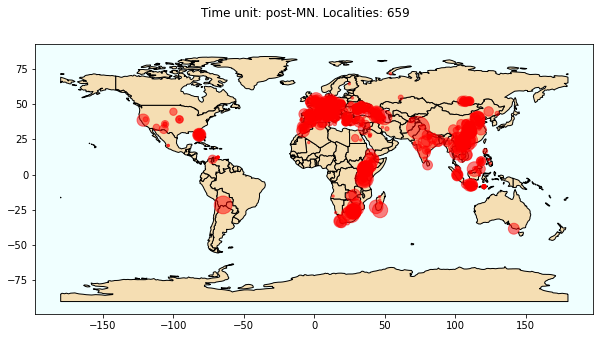

In [7]:
# Plotting localities in every time unit based on instruction 5 b.
def plot_locations():
    locations = location_df()
    for MN in MN_UNITS:
        fig, ax = plt.subplots(figsize=(10, 5))
        world.plot(ax=ax, color='wheat', edgecolor='black')
        ax.set_facecolor('azure')
        
        time_unit = locations[locations['MN'] == MN] # Get localities for specific time unit
        plt.suptitle(f'Time unit: {MN}. Localities: {len(time_unit)}')
        # Plot coordinates with dynamic marker size
        plt.scatter(x=time_unit.LONG, y=time_unit.LAT, s=time_unit.ALL_OCC*6, c='red', alpha=0.5)
    plt.show()

if __name__ == '__main__':
    plot_locations()

I assumed the instructions meant that I will need to plot all of the 19 or so time units. So there they are. You can see how the occurences seemed to be moving in waves; less occurences -> more occurences in the next time period -> ... and so on.

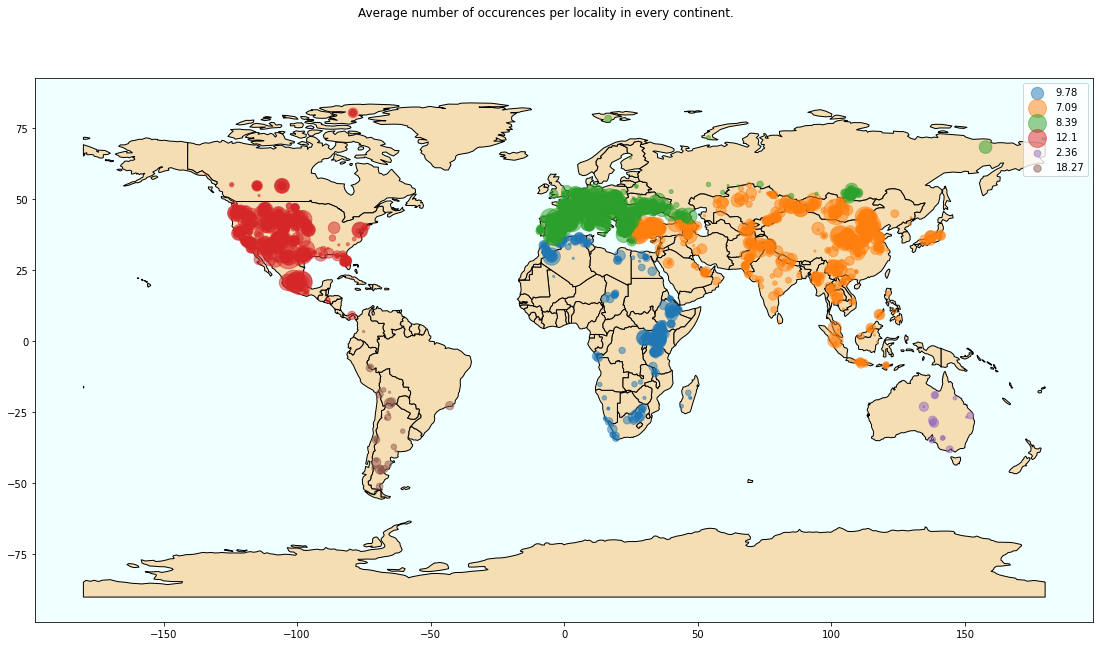

In [8]:
# Plotting localities for different continents based on instruction 5 c.
def plot_continental_info():
    locations = location_df()
    ax = world.plot(color='wheat', edgecolor='black', figsize=(20, 10))
    ax.set_facecolor('azure')
    
    # Creating geopandas DataFrame for joining
    gdf = geopandas.GeoDataFrame(locations, geometry=geopandas.points_from_xy(locations.LONG, locations.LAT))
    gdf.set_crs(epsg=4326, inplace=True)
    
    # Joining locality data with the world map and grouping by continent
    combined = geopandas.tools.sjoin(gdf, world, how='left').groupby('continent')
    combined.plot(ax=ax, markersize=locations.ALL_OCC*5, alpha=0.5) # Plotting the data with dynamic markersize
    
    continent_data = combined.agg('mean') # Getting average occurnces for every locality in each continent
    
    plt.suptitle('Average number of occurences per locality in every continent.')
    ax.legend(round(continent_data.ALL_OCC, 2))
    plt.show()

if __name__ == '__main__':
    plot_continental_info()

### Answer
I should be using `LIDNUM` because some of the findings have the same locality names with different `LIDNUM`; it helps to further improve the accuracy of the analysis. (there also might be same names for different places)

5. c) There are some sampling density changes, most notable are `MN1`, `MN2` and `MN14`; `post- and pre-MN` aren't included since their sample size is much larger compared to the other time units. The rest is around the median.<br> The second plot section shows average number of occurences per locality for every continent. `South America` with the most occurences `(18.27)` and `Australia` with the least amount of occurences `(2.36)`.

## Localities and sampling

6. For every locaclity get 10x10 area of nearby localities and sum their all and first occurences for the focal locality's time unit. Also get the previous time unit's all occurences.

In [9]:
def check_previous_mn(idx, mn, mn_groups):
    tu = list(MN_UNITS.keys())
    previous_mn = tu.index(mn_groups[idx])-1
    if tu[previous_mn] == mn:
        return True
    return False


def square_localities():
    locations = location_df()
    # Creating geopandas DataFrame for joining
    gdf = geopandas.GeoDataFrame(locations, geometry=geopandas.points_from_xy(locations.LONG, locations.LAT))
    gdf.set_crs(epsg=3395, inplace=True)
    mn_groups = gdf.MN.to_dict() # Current time periods for every group in a dict is faster to use
    
    buffer = gdf.buffer(5, cap_style=3) # Create a 10x10 square around the localities
    buffer = geopandas.GeoDataFrame(geometry=buffer).to_crs(3395) # GeoSeries -> GeoDataFrame for faster intersection
    
    # Join and groupby index to get every 10x10 square of localities
    inside_area = geopandas.tools.sjoin(buffer, gdf, how='left', op='contains')
    inside_area[['FIRST', 'ALL']] = inside_area.groupby([inside_area.index, 'MN'])[['FIRST_OCC', 'ALL_OCC']].transform(sum)
    
    # Getting all and first occurences in the focal time unit
    focal_mn = inside_area[[True if mn_groups[idx] == mn else False for idx, mn in zip(inside_area.index, inside_area['MN'])]]
    focal_mn = focal_mn[~focal_mn.index.duplicated(keep='first')]
    
    # Getting all occurences in the previous time unit
    before_focal = inside_area[[check_previous_mn(idx, mn, mn_groups) for idx, mn in zip(inside_area.index, inside_area['MN'])]]
    before_focal = before_focal[~before_focal.index.duplicated(keep='first')]
    
    # Adding new new data to the exercise 5 DataFrame
    locations = locations.assign(FOCAL_ALL=focal_mn.ALL, FOCAL_FIRST=focal_mn.FIRST, PREVIOUS_ALL=before_focal.ALL)
    locations.drop('geometry', axis=1, inplace=True) # Drop geometry column because it's not needed
#     locations.dropna(subset = ["PREVIOUS_ALL"], inplace=True) # Used to drop all rows without a previous time unit
    return locations


if __name__ == '__main__':
    square_localities()

### Answer

This probably isn't the optimal solution since it takes some time to run but It gives the correct `DataFrame`. The most time consuming part is the one instance of `geopandas sjoin` method with its staggering **2.2 million rows**. Giving sjoin the parameter `op='contains'` speeds it up a bit.

Notes: It wasn't specified what you should do if locality doesn't have a previous time unit so I returned NaN values for those since it seemed to be the right thing to do considering we are going to use the data for regression.